# Offical

## Load du lieu

In [22]:
import pandas as pd
file_name ='data_10y.csv'
data = pd.read_csv(file_name, header=[0, 1], index_col=0, parse_dates=True)

In [23]:
df_close = data['Close']
df_close = df_close.ffill

In [24]:
df_close = df_close()
split_point = int(len(df_close) * 0.8)
df_kd_train = df_close.iloc[:split_point]
df_kd_test = df_close.iloc[split_point:]

##Kiem dinh tiem cap

###Hàm

In [25]:
from statsmodels.tsa.stattools import coint

def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.columns
    pairs = []

    print("Đang chạy kiểm định Engle-Granger...")
    for i in range(n):
        for j in range(i+1, n): # Tránh lặp lại và tự so sánh
            s1 = data[keys[i]]
            s2 = data[keys[j]]

            # Kiểm định coint từ statsmodels
            # Hàm này thực hiện cả hồi quy và kiểm định ADF trên phần dư
            result = coint(s1, s2)
            score = result[0]
            pvalue = result[1]

            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue

            if pvalue < 0.05:
                pairs.append((keys[i], keys[j], pvalue))
                print(f"Cặp đồng liên kết tìm thấy: {keys[i]} - {keys[j]} (p-value: {pvalue:.4f})")

    return score_matrix, pvalue_matrix, pairs

In [26]:
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import numpy as np

def calc_half_life(spread):
    """Tính half-life theo OU process"""
    spread_lag = spread.shift(1).dropna()
    spread_ret = spread.diff().dropna()

    model = sm.OLS(spread_ret, sm.add_constant(spread_lag)).fit()
    beta = model.params.iloc[1]

    if beta >= 0:   # tránh log dương hoặc zero gây lỗi
        return np.inf

    halflife = -np.log(2) / beta
    return halflife


def hurst_exponent(ts):
    """Tính Hurst exponent"""
    lags = range(2, 100)
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    hurst = poly[0] * 2.0
    return hurst

###Tiến hành

Đang chạy kiểm định Engle-Granger...
Cặp đồng liên kết tìm thấy: BID.VN - VCB.VN (p-value: 0.0034)
Cặp đồng liên kết tìm thấy: CTG.VN - HPG.VN (p-value: 0.0088)
Cặp đồng liên kết tìm thấy: CTG.VN - MBB.VN (p-value: 0.0488)


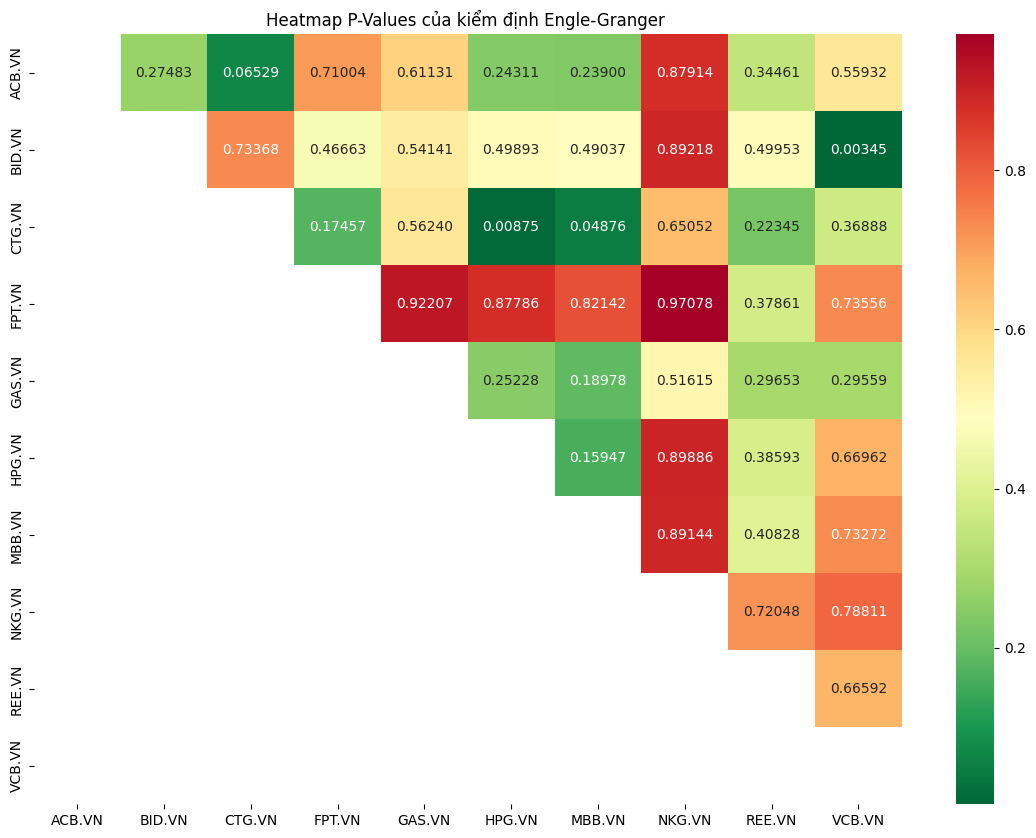

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Chạy trên dữ liệu Log Prices
df_kd_train = np.log(df_kd_train)
scores, pvalues, cointegrated_pairs = find_cointegrated_pairs(df_kd_train)

# Vẽ Heatmap P-values để dễ quan sát
plt.figure(figsize=(14, 10))
sns.heatmap(pvalues, xticklabels=df_kd_train.columns, yticklabels=df_kd_train.columns,
            cmap='RdYlGn_r', mask=(pvalues >= 0.99), annot=True, fmt=".5f")
plt.title("Heatmap P-Values của kiểm định Engle-Granger ")
plt.show()

In [28]:
# ============================================================
# KIỂM ĐỊNH TOÀN BỘ CÁC CẶP
# ============================================================

for s1, s2, p in cointegrated_pairs:
    print(f"\n=== Kiểm định cho spread {s1} - {s2} ===")

    # Use df_close which contains all columns instead of df
    y = df_kd_train[s1]
    x = df_kd_train[s2]

    # Loại bỏ NaN
    valid_idx = y.notna() & x.notna()
    y = y[valid_idx]
    x = x[valid_idx]

    # OLS để lấy residual (spread)
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    resid = model.resid

    # ---- ADF TEST ----
    adf_stat, adf_pvalue, _, _, crit, _ = adfuller(resid)
    if adf_pvalue <= 0.05:
      print(f"ADF Statistic : {adf_stat:.4f}")
      print(f"ADF p-value   : {adf_pvalue:.4f}")
      print(f"Critical Values: {crit}")

      # ---- HALF-LIFE ----
      hl = calc_half_life(resid)
      print(f"Half-life     : {hl:.2f}")

      # ---- HURST EXPONENT ----
      hurst = hurst_exponent(resid.values)
      print(f"Hurst Exponent: {hurst:.4f}")
    else:
      print(f'Thất bại')


=== Kiểm định cho spread BID.VN - VCB.VN ===
ADF Statistic : -4.2159
ADF p-value   : 0.0006
Critical Values: {'1%': np.float64(-3.4336320721769433), '5%': np.float64(-2.862989840784964), '10%': np.float64(-2.56754183359401)}
Half-life     : 37.38
Hurst Exponent: 0.4212

=== Kiểm định cho spread CTG.VN - HPG.VN ===
ADF Statistic : -3.9386
ADF p-value   : 0.0018
Critical Values: {'1%': np.float64(-3.4336320721769433), '5%': np.float64(-2.862989840784964), '10%': np.float64(-2.56754183359401)}
Half-life     : 48.19
Hurst Exponent: 0.3826

=== Kiểm định cho spread CTG.VN - MBB.VN ===
ADF Statistic : -3.3474
ADF p-value   : 0.0129
Critical Values: {'1%': np.float64(-3.433648628001351), '5%': np.float64(-2.8629971502062155), '10%': np.float64(-2.5675457254979093)}
Half-life     : 76.55
Hurst Exponent: 0.4698


Dựa vào kết quả kiểm định thì nên chọn BID.VN - VCB.VN cho ngắn hạn, CTG.VN - HPG.VN cho dài hạn
- Half-life: 37.38 số ngày cần để hội tụ về mean-reversion ( càng ngắn càng đảo chiều nhanh)
- ADF p-value : chuỗi dừng với độ tin cậy
- Hurst Exponent: < 0.5 chuỗi có có xu hướng đảo chiều và nhanh chóng (càng gần 0 càng đảo mạnh) quay trở lại mức cân bằng dài hạn


##Tính các chỉ số cần thiết (chỉ có hàm)

In [29]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS # Thư viện vectorization

def pair_trading_signals(df, col1, col2, window=30):
    """
    Tối ưu hóa việc tính toán các chỉ số Pair Trading bằng RollingOLS.
    """
    df = df.copy()

    # --- 1. Log price series ---
    log1 = np.log(df[col1])
    log2 = np.log(df[col2])

    # --- 2. Rolling OLS (Vectorized) ---
    # Sử dụng log2 (X) làm biến độc lập và thêm hằng số
    X = sm.add_constant(log2)
    Y = log1

    # Khởi tạo và chạy Rolling OLS
    rols = RollingOLS(Y, X, window=window)
    rres = rols.fit()

    # Gán Beta và Alpha (mu)
    df['mu'] = rres.params['const'] # Alpha (intercept)
    df['beta'] = rres.params[col2]  # Beta (slope)

    # --- 3. Tính Spread (Phần dư) ---
    # Spread = log(P1) - alpha - beta * log(P2)
    # Ta phải điền NaN cho phần dữ liệu ban đầu (window-1 ngày)
    df['spread'] = log1 - df['mu'] * log1.apply(lambda x: 1) - df['beta'] * log2

    # Loại bỏ NaN nếu có (do không đủ window)
    df = df.dropna(subset=['beta', 'mu', 'spread'])

    # --- 4. Tính Z-score và Volatility ---
    # Lưu ý: Rolling Mean/Std của spread phải được tính trên CHÍNH SPREAD
    df['spread_mean'] = df['spread'].rolling(window).mean()
    df['spread_std'] = df['spread'].rolling(window).std()
    df['zscore'] = (df['spread'] - df['spread_mean']) / df['spread_std']
    df['spread_vol'] = df['spread_std']

    # --- Cleanup ---
    # Loại bỏ lại NaN cho rolling window đầu tiên (do mean/std cần window ngày)
    df = df.dropna(subset=['zscore', 'spread_mean'])

    return df

##Các chiến luợc (long-short, only-long)

###Long-Short

In [30]:
import pandas as pd
import numpy as np

def backtest_pair_long_short(
    df,
    col1="BID.VN",
    col2="VCB.VN",
    beta_col="beta",
    zscore_col="zscore",
    spread_vol="spread_vol",
    entry_z=1.0,
    exit_z=0.0,
    max_risk_per_trade=0.02,
    initial_cash=100_000_000,
    buy_fee=0.001,
    sell_fee=0.002,
    allow_short=False,
    # stop_loss_pct=0.05, # Tạm thời loại bỏ để đơn giản hóa quá trình tối ưu
    vol_lower=0.0005,
    vol_upper_quantile=0.95 # Dùng Quantile thay vì giá trị cố định
):

    df = df.copy()

    # SHIFT beta, zscore, volatility (Đúng - dùng dữ liệu ngày T-1 để giao dịch ngày T)
    df[beta_col] = df[beta_col].shift(1)
    df[zscore_col] = df[zscore_col].shift(1)
    df[spread_vol] = df[spread_vol].shift(1)

    cash = initial_cash
    pos1 = 0
    pos2 = 0
    prev_equity = initial_cash
    total_trades = 0

    # Khởi tạo các cột đầu ra
    df["hold1"] = 0
    df["hold2"] = 0
    df["cash"] = 0.0
    df["equity"] = 0.0
    df["daily_pnl"] = 0.0
    df["trades"] = 0

    # Tính toán ngưỡng Volatility Quantile trên dữ liệu quá khứ (LOẠI BỎ LOOK-AHEAD BIAS)
    # Tính Quantile trên cửa sổ cố định/rolling, hoặc đơn giản là dùng giá trị cố định
    # Tạm thời loại bỏ ràng buộc Volatility để tập trung vào logic đóng/mở

    # Để tránh Look-ahead Bias, ta lấy vol_upper cố định (hoặc loại bỏ hoàn toàn ràng buộc này)
    # Nếu muốn dùng ràng buộc volatility, nên tính quantile trên cửa sổ rolling

    # ****************** LƯU Ý SỬA LỖI VOLATILITY ******************
    # có thể đặt vol_upper_fixed = 0.02 nếu muốn ràng buộc.
    # **************************************************************

    for i in range(len(df)):
        price1 = float(df.iloc[i][col1])
        price2 = float(df.iloc[i][col2])
        beta = df.iloc[i][beta_col]
        z = df.iloc[i][zscore_col]
        spread_vol_i = df.iloc[i][spread_vol] # Volatility tại ngày T-1

        # Skip missing values
        if pd.isna(beta) or pd.isna(z):
            # ... (Phần này giữ nguyên) ...
            df.iloc[i, df.columns.get_loc("hold1")] = pos1
            df.iloc[i, df.columns.get_loc("hold2")] = pos2
            df.iloc[i, df.columns.get_loc("cash")] = cash
            df.iloc[i, df.columns.get_loc("equity")] = cash + pos1 * price1 + pos2 * price2
            df.iloc[i, df.columns.get_loc("daily_pnl")] = 0.0
            df.iloc[i, df.columns.get_loc("trades")] = 0
            continue

        nav = cash + pos1 * price1 + pos2 * price2
        trades_today = 0

        # -------------------------------------------------------------
        # Ràng buộc Volatility đã được sửa đổi (Fixed Upper Bound)
        # Giả định vol_upper_fixed = 0.02 (hoặc giá trị cố định bạn muốn)
        # Nếu muốn dùng vol_upper_quantile, phải tính rolling quantile
        # Tạm thời chỉ kiểm tra vol_lower để cho phép nhiều giao dịch hơn trong tối ưu
        vol_allow = spread_vol_i > vol_lower # Loại bỏ vol_upper ràng buộc Look-ahead Bias
        # -------------------------------------------------------------

        # Position sizing
        max_leg_value = nav * max_risk_per_trade

        # Đảm bảo mẫu số không bằng 0
        denominator = price1 + abs(beta) * price2
        if denominator == 0:
             qty1 = 0
        else:
             qty1 = int(max_leg_value / denominator)

        qty2 = int(qty1 * abs(beta))


        # -------------------------------------------------------------
        # LOGIC GIAO DỊCH (ENTRY)
        # -------------------------------------------------------------

        # ENTRY - High spread (z > entry_z) → short 1, long 2
        if z > entry_z and pos1 == 0 and pos2 == 0 and vol_allow:

            # ... (Logic Position Sizing và Cash Check như cũ) ...
            sell_qty1 = qty1
            buy_qty2 = qty2

            net_cash_needed = buy_qty2*price2*(1+buy_fee) - sell_qty1*price1*(1-sell_fee)
            if net_cash_needed > cash:
                factor = cash / net_cash_needed if net_cash_needed > 0 else 0
                buy_qty2 = int(buy_qty2*factor)
                sell_qty1 = int(sell_qty1*factor)

            # Thực hiện giao dịch (chỉ khi đủ cash và không vi phạm allow_short)
            if allow_short or cash >= net_cash_needed: # Kiểm tra cash thay vì pos1 >= sell_qty1
                 cash += sell_qty1*price1*(1-sell_fee)
                 pos1 -= sell_qty1 # Short pos1
                 cash -= buy_qty2*price2*(1+buy_fee)
                 pos2 += buy_qty2 # Long pos2
                 trades_today += 1

        # ENTRY - Low spread (z < -entry_z) → long 1, short 2
        elif z < -entry_z and pos1 == 0 and pos2 == 0 and vol_allow:

            # ... (Logic Position Sizing và Cash Check như cũ) ...
            buy_qty1 = qty1
            sell_qty2 = qty2

            net_cash_needed = buy_qty1*price1*(1+buy_fee) - sell_qty2*price2*(1-sell_fee)
            if net_cash_needed > cash:
                factor = cash / net_cash_needed if net_cash_needed > 0 else 0
                buy_qty1 = int(buy_qty1*factor)
                sell_qty2 = int(sell_qty2*factor)

            # Thực hiện giao dịch (chỉ khi đủ cash và không vi phạm allow_short)
            if allow_short or cash >= net_cash_needed: # Kiểm tra cash thay vì pos2 >= sell_qty2
                cash -= buy_qty1*price1*(1+buy_fee)
                pos1 += buy_qty1 # Long pos1
                cash += sell_qty2*price2*(1-sell_fee)
                pos2 -= sell_qty2 # Short pos2
                trades_today += 1

        # -------------------------------------------------------------
        # LOGIC ĐÓNG VỊ THẾ HOÀN TOÀN (EXIT) - Đã sửa lỗi đóng một phần
        # -------------------------------------------------------------
        elif abs(z) < exit_z and (pos1 != 0 or pos2 != 0): # Đã có vị thế mở

            # Số lượng đóng phải bằng vị thế đang giữ
            close_qty1 = abs(pos1)
            close_qty2 = abs(pos2)

            # Chỉ đóng nếu có đủ cash cho các giao dịch đóng/mua lại
            # Đối với Short sale (pos < 0), ta phải mua lại (cash giảm)
            # Giả định luôn có đủ cash để mua lại vị thế Short

            can_close = True # Giả định luôn có thể đóng vị thế

            if can_close:
                # Đóng Leg 1
                if pos1 > 0: # Đang Long 1 -> Bán 1
                    cash += close_qty1 * price1 * (1 - sell_fee)
                elif pos1 < 0: # Đang Short 1 -> Mua lại 1
                    cash -= close_qty1 * price1 * (1 + buy_fee)
                pos1 = 0

                # Đóng Leg 2
                if pos2 > 0: # Đang Long 2 -> Bán 2
                    cash += close_qty2 * price2 * (1 - sell_fee)
                elif pos2 < 0: # Đang Short 2 -> Mua lại 2
                    cash -= close_qty2 * price2 * (1 + buy_fee)
                pos2 = 0

                trades_today += 1 # Ghi nhận 1 giao dịch đóng

        # -------------------------------------------------------------
        # LOGIC DỪNG LỖ (SL) - Tạm thời chưa có
        # -------------------------------------------------------------
        #

        # Mark-to-market
        equity = cash + pos1*price1 + pos2*price2
        daily_pnl = equity - prev_equity
        prev_equity = equity

        # ... (Phần ghi log dữ liệu giữ nguyên) ...
        df.iloc[i, df.columns.get_loc("hold1")] = pos1
        df.iloc[i, df.columns.get_loc("hold2")] = pos2
        df.iloc[i, df.columns.get_loc("cash")] = cash
        df.iloc[i, df.columns.get_loc("equity")] = equity
        df.iloc[i, df.columns.get_loc("daily_pnl")] = daily_pnl
        df.iloc[i, df.columns.get_loc("trades")] = trades_today

        total_trades += trades_today

    # ====================================================================
    # TÍNH TOÁN HIỆU SUẤT (Giữ nguyên, logic tính đúng rồi)
    # ====================================================================
    df["return"] = df["equity"].pct_change()

    # Số ngày giao dịch thực tế (bỏ qua NaN)
    n_days = df.iloc[1:]["return"].count()

    total_return = df["equity"].iloc[-1] / initial_cash - 1

    if n_days > 0:
        # Giả sử 252 ngày giao dịch trong 1 năm
        cagr = (1 + total_return) ** (252 / n_days) - 1
        volatility = df["return"].std() * np.sqrt(252)
        sharpe = cagr / volatility if volatility != 0 else np.nan
    else:
        cagr = volatility = sharpe = np.nan

    performance = {
        "Final Equity": df["equity"].iloc[-1],
        "Net P/L": df["equity"].iloc[-1] - initial_cash,
        "Annualized Return": cagr,      # Tên cột đã được sửa để phù hợp với hàm make_objective_sharpe
        "Annualized Volatility": volatility, # Tên cột đã được sửa
        "Sharpe Ratio": sharpe,
        "Total Trades": total_trades
    }

    # Chuyển đổi sang % và làm tròn cho output in ra
    # Tuy nhiên, trả về giá trị thô (float) để tính toán chính xác trong hàm tối ưu

    # print({k: (round(v * 100, 2) if isinstance(v, (float, np.float64)) and v < 1 and k in ["Annualized Return", "Annualized Volatility"] else round(v, 2)) for k, v in performance.items() if k not in ["Final Equity", "Net P/L"]})

    # Đảm bảo trả về các chỉ số dưới dạng FLOAT chính xác:
    perf_return = {
         "Final Equity": performance["Final Equity"],
         "Net P/L": performance["Net P/L"],
         "Annualized Return": performance["Annualized Return"],
         "Annualized Volatility": performance["Annualized Volatility"],
         "Sharpe Ratio": performance["Sharpe Ratio"],
         "Total Trades": performance["Total Trades"]
    }

    return df, perf_return

###Only Long

In [31]:
def backtest_long_only_switching(
    df, col1, col2,
    beta_col="beta", zscore_col="zscore",
    entry_z=1.0, exit_z=0.0,
    initial_cash=100_000_000,
    buy_fee=0.001, sell_fee=0.002,
    max_risk_per_trade=0.2 # Tỷ lệ NAV tối đa dùng cho mỗi giao dịch (VD: 20%)
):
    df = df.copy()
    risk_free_rate = 0.02 # Giả định lãi suất phi rủi ro

    # 1. SHIFT (Chống Look-ahead Bias)
    df[zscore_col] = df[zscore_col].shift(1)

    cash = initial_cash
    pos1 = 0
    pos2 = 0
    prev_equity = initial_cash
    total_trades = 0

    # Khởi tạo cột
    for col in ["hold1", "hold2", "cash", "equity", "daily_pnl", "trades"]:
        df[col] = 0.0

    for i in range(len(df)):
        price1 = float(df.iloc[i][col1])
        price2 = float(df.iloc[i][col2])
        z = df.iloc[i][zscore_col]

        if pd.isna(z):
            # Cập nhật trạng thái nếu NaN
            equity = cash + pos1 * price1 + pos2 * price2
            df.iloc[i, df.columns.get_loc("cash")] = cash
            df.iloc[i, df.columns.get_loc("equity")] = equity
            df.iloc[i, df.columns.get_loc("hold1")] = pos1
            df.iloc[i, df.columns.get_loc("hold2")] = pos2
            df.iloc[i, df.columns.get_loc("daily_pnl")] = 0.0
            continue

        nav = cash + pos1 * price1 + pos2 * price2
        trades_today = 0

        # 2. LOGIC ĐÓNG VỊ THẾ HOÀN TOÀN (EXIT)
        if abs(z) < exit_z and (pos1 != 0 or pos2 != 0):

            if pos1 > 0: # Đang Long 1 -> Bán 1
                close_qty = pos1
                cash += close_qty * price1 * (1 - sell_fee)
                pos1 = 0
                trades_today += 1

            if pos2 > 0: # Đang Long 2 -> Bán 2
                close_qty = pos2
                cash += close_qty * price2 * (1 - sell_fee)
                pos2 = 0
                trades_today += 1

        # 3. LOGIC MỞ VỊ THẾ (ENTRY) - Chỉ mở khi đang KHÔNG có vị thế nào
        elif abs(z) >= entry_z and pos1 == 0 and pos2 == 0:

            # QUẢN LÝ VỐN: Dùng max_risk_per_trade của NAV hiện tại
            capital_to_use = nav * max_risk_per_trade
            investment_amount = min(capital_to_use, cash) # Không vượt quá Cash

            # Entry 1: Z < -entry_z (Long Leg 1 - Mua cổ phiếu 1)
            if z <= -entry_z:
                qty1 = int(investment_amount / (price1 * (1 + buy_fee)))
                if qty1 > 0:
                    cash -= qty1 * price1 * (1 + buy_fee)
                    pos1 += qty1
                    trades_today += 1

            # Entry 2: Z > entry_z (Long Leg 2 - Mua cổ phiếu 2)
            elif z >= entry_z:
                qty2 = int(investment_amount / (price2 * (1 + buy_fee)))
                if qty2 > 0:
                    cash -= qty2 * price2 * (1 + buy_fee)
                    pos2 += qty2
                    trades_today += 1

        # 4. Mark-to-market và Ghi log
        equity = cash + pos1*price1 + pos2*price2
        daily_pnl = equity - prev_equity
        prev_equity = equity

        df.iloc[i, df.columns.get_loc("cash")] = cash
        df.iloc[i, df.columns.get_loc("equity")] = equity
        df.iloc[i, df.columns.get_loc("hold1")] = pos1
        df.iloc[i, df.columns.get_loc("hold2")] = pos2
        df.iloc[i, df.columns.get_loc("daily_pnl")] = daily_pnl
        df.iloc[i, df.columns.get_loc("trades")] = trades_today

        total_trades += trades_today

    # 5. Tính Hiệu suất Cuối cùng
    df["return"] = df["equity"].pct_change()
    n_days = df["return"].count()
    total_return = df["equity"].iloc[-1] / initial_cash - 1

    if n_days > 0:
        cagr = (1 + total_return) ** (252 / n_days) - 1
        volatility = df["return"].std() * np.sqrt(252)
        sharpe = (cagr - risk_free_rate) / volatility if volatility != 0 else np.nan
    else:
        cagr = volatility = sharpe = np.nan

    performance = {
        "Final Equity": df["equity"].iloc[-1],
        "Net P/L": df["equity"].iloc[-1] - initial_cash,
        "Annualized Return": cagr,
        "Annualized Volatility": volatility,
        "Sharpe Ratio": sharpe,
        "Total Trades": total_trades
    }

    return df, performance

##Tối ưu tham số

In [32]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 24.1 MB/s eta 0:00:00


In [33]:
import optuna
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import warnings

warnings.filterwarnings("ignore")

def optimize_pair_optuna(
    df,
    col1="BID.VN",
    col2="VCB.VN",
    n_trials=40,
    n_splits=4,
    initial_cash=100_000_000,
    min_trade = 20
):
    print("\nRunning Optuna optimization...")

    tscv = TimeSeriesSplit(n_splits=n_splits)

    def objective(trial, allow_short):

        # ==============================
        # Sample tham số cần tối ưu
        # ==============================
        window      = trial.suggest_int("window", 25, 40)
        entry_z     = trial.suggest_float("entry_z", 1.5, 3.0)
        exit_z      = trial.suggest_float("exit_z", 0.3, 1.5)
        max_risk    = trial.suggest_float("max_risk_per_trade", 0.05, 0.4)
        vol_lower   = trial.suggest_float("vol_lower", 0.0003, 0.002)

        sharpe_scores = []

        # ==============================
        # Time-Series CV
        # ==============================
        for fold, (train_idx, test_idx) in enumerate(tscv.split(df)):

            df_train = df.iloc[train_idx].copy()
            df_test = df.iloc[test_idx].copy()

            # Tính tín hiệu trên train + test (để không thiếu data rolling)
            df_total = pair_trading_signals(pd.concat([df_train, df_test], axis=0)
                                               ,col1
                                               ,col2
                                               ,window)

            # Lấy đúng đoạn test để backtest
            df_sig_test = df_total.iloc[len(df_train):].copy()

            try:
                _, perf = backtest_pair_long_short(
                    df_sig_test,
                    col1=col1,
                    col2=col2,
                    entry_z=entry_z,
                    exit_z=exit_z,
                    max_risk_per_trade=max_risk,
                    allow_short=allow_short,
                    vol_lower=vol_lower,
                    initial_cash=initial_cash
                )

                sharpe = perf["Sharpe Ratio"]

                # Loại fold lỗi hoặc quá ít giao dịch
                if np.isnan(sharpe) or perf["Total Trades"] < min_trade:
                    return -999

                sharpe_scores.append(sharpe)

            except Exception:
                return -999

        return np.mean(sharpe_scores)

    # =====================================
    # Tạo 2 study: Long-Short & Only-Long
    # =====================================
    studies = {}
    modes = {"LS": True, "ONLY_LONG": False}

    for mode, allow_short in modes.items():

        study = optuna.create_study(
            direction="maximize",
            sampler=optuna.samplers.TPESampler(seed=42)
        )

        print(f"\nOptimizing mode: {mode}")
        study.optimize(lambda trial: objective(trial, allow_short), n_trials=n_trials)

        studies[mode] = study

    # =====================================
    # Chọn mode tốt nhất
    # =====================================
    best_mode = max(studies, key=lambda m: studies[m].best_value)
    best_study = studies[best_mode]

    print("\nTối ưu hoàn tất!")
    print(f"Best Mode: {best_mode}")
    print(f"Best Sharpe: {best_study.best_value:.4f}")
    print(f"Best Params: {best_study.best_params}")

    return best_mode, best_study.best_params, studies


##BID.VN - VCB.VN
- ngắn hạn hơn nhưng hurst nhỏ: kiếm được lời ít hơn trong khoảng thời gian ngắn hơn

In [34]:
import pandas as pd
# 2 cols lấy từ cặp kiểm định có thể tùy chỉnh
col1, col2 = 'BID.VN','VCB.VN'
data = pd.read_csv('data_10y.csv', header=[0, 1], index_col=0, parse_dates=True)
df = pd.DataFrame({
    col1: data['Close'][col1],
    col2: data['Close'][col2]
})

df = df.ffill()
split_point = int(len(df) * 0.8)
df_train = df.iloc[:split_point]
df_test = df.iloc[split_point:]

In [35]:
best_mode, best_params, all_studies = optimize_pair_optuna(
    df_train, # tập này bị tách thành train - validation
    col1= col1,
    col2= col2,
    n_trials=50 #,min_trade được điều chỉnh dựa trên thời gian test
)


[I 2025-12-13 03:15:45,193] A new study created in memory with name: no-name-26803988-c9c5-4723-aba4-b087317bd937



Running Optuna optimization...

Optimizing mode: LS


[I 2025-12-13 03:15:46,480] Trial 0 finished with value: -999.0 and parameters: {'window': 30, 'entry_z': 2.9260714596148745, 'exit_z': 1.178392730173686, 'max_risk_per_trade': 0.25953046946896285, 'vol_lower': 0.0005652316887521421}. Best is trial 0 with value: -999.0.
[I 2025-12-13 03:15:52,016] Trial 1 finished with value: -0.016625285803176515 and parameters: {'window': 27, 'entry_z': 1.5871254182522991, 'exit_z': 1.3394113749299221, 'max_risk_per_trade': 0.2603902541101231, 'vol_lower': 0.0015037233822532774}. Best is trial 1 with value: -0.016625285803176515.
[I 2025-12-13 03:15:54,279] Trial 2 finished with value: -999.0 and parameters: {'window': 25, 'entry_z': 2.9548647782429915, 'exit_z': 1.298931168960506, 'max_risk_per_trade': 0.12431868873739667, 'vol_lower': 0.000609102444252071}. Best is trial 1 with value: -0.016625285803176515.
[I 2025-12-13 03:16:02,342] Trial 3 finished with value: 0.3512515345562328 and parameters: {'window': 27, 'entry_z': 1.9563633644393066, 'exit


Optimizing mode: ONLY_LONG


[I 2025-12-13 03:17:54,060] Trial 0 finished with value: -999.0 and parameters: {'window': 30, 'entry_z': 2.9260714596148745, 'exit_z': 1.178392730173686, 'max_risk_per_trade': 0.25953046946896285, 'vol_lower': 0.0005652316887521421}. Best is trial 0 with value: -999.0.
[I 2025-12-13 03:17:56,547] Trial 1 finished with value: -0.016625285803176515 and parameters: {'window': 27, 'entry_z': 1.5871254182522991, 'exit_z': 1.3394113749299221, 'max_risk_per_trade': 0.2603902541101231, 'vol_lower': 0.0015037233822532774}. Best is trial 1 with value: -0.016625285803176515.
[I 2025-12-13 03:17:57,120] Trial 2 finished with value: -999.0 and parameters: {'window': 25, 'entry_z': 2.9548647782429915, 'exit_z': 1.298931168960506, 'max_risk_per_trade': 0.12431868873739667, 'vol_lower': 0.000609102444252071}. Best is trial 1 with value: -0.016625285803176515.
[I 2025-12-13 03:17:59,625] Trial 3 finished with value: 0.3512515345562328 and parameters: {'window': 27, 'entry_z': 1.9563633644393066, 'exit


Tối ưu hoàn tất!
Best Mode: LS
Best Sharpe: 0.6255
Best Params: {'window': 28, 'entry_z': 2.0415714362090887, 'exit_z': 1.0497506947390534, 'max_risk_per_trade': 0.18816412373268512, 'vol_lower': 0.00139795594919551}


In [36]:
df_sig = pair_trading_signals(df_test, col1, col2, window=best_params["window"])

df_res1, final_perf1 = backtest_pair_long_short(
    df_sig,
    entry_z=best_params["entry_z"],
    exit_z=best_params["exit_z"],
    max_risk_per_trade=best_params["max_risk_per_trade"],
    allow_short = (best_mode == "LS"),
)

print(final_perf1)


{'Final Equity': np.float64(100832232.11816806), 'Net P/L': np.float64(832232.118168056), 'Annualized Return': np.float64(0.004704393246909522), 'Annualized Volatility': np.float64(0.016224739645043337), 'Sharpe Ratio': np.float64(0.2899518482163574), 'Total Trades': 32}


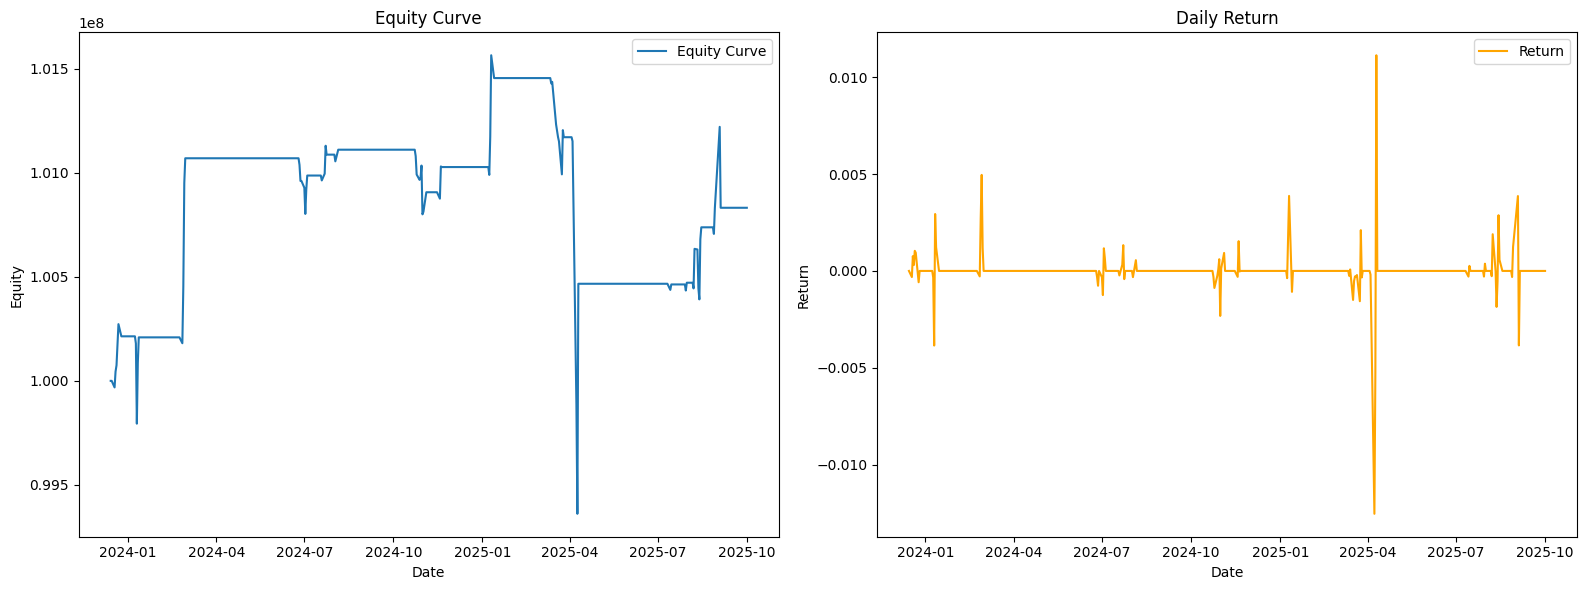

In [37]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Equity Curve
axes[0].plot(df_res1["equity"], label='Equity Curve')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Equity')
axes[0].set_title('Equity Curve')
axes[0].legend()

# Plot Return
axes[1].plot(df_res1["return"], label='Return', color='orange')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Return')
axes[1].set_title('Daily Return')
axes[1].legend()

plt.tight_layout() #
plt.show()

## CTG.VN - HPG.VN

In [38]:
import pandas as pd
# 2 cols lấy từ cặp kiểm định có thể tùy chỉnh
col1, col2 = 'CTG.VN','HPG.VN'
data = pd.read_csv('data_10y.csv', header=[0, 1], index_col=0, parse_dates=True)
df = pd.DataFrame({
    col1: data['Close'][col1],
    col2: data['Close'][col2]
})

df = df.ffill()
split_point = int(len(df) * 0.8)
df_train = df.iloc[:split_point]
df_test = df.iloc[split_point:]

In [39]:
best_mode, best_params, all_studies = optimize_pair_optuna(
    df_train, # tập này bị tách thành train - validation
    col1= col1,
    col2= col2,
    n_trials=50,# min_trade phải được chỉnh sửa theo thời gian hoạt động, trường hợp 2 năm thì cỡ 20
)

[I 2025-12-13 03:19:39,048] A new study created in memory with name: no-name-3b60c765-55c1-4c70-b319-35dab20ebd71



Running Optuna optimization...

Optimizing mode: LS


[I 2025-12-13 03:19:39,635] Trial 0 finished with value: -999.0 and parameters: {'window': 30, 'entry_z': 2.9260714596148745, 'exit_z': 1.178392730173686, 'max_risk_per_trade': 0.25953046946896285, 'vol_lower': 0.0005652316887521421}. Best is trial 0 with value: -999.0.
[I 2025-12-13 03:19:42,142] Trial 1 finished with value: -0.8302900657629548 and parameters: {'window': 27, 'entry_z': 1.5871254182522991, 'exit_z': 1.3394113749299221, 'max_risk_per_trade': 0.2603902541101231, 'vol_lower': 0.0015037233822532774}. Best is trial 1 with value: -0.8302900657629548.
[I 2025-12-13 03:19:42,721] Trial 2 finished with value: -999.0 and parameters: {'window': 25, 'entry_z': 2.9548647782429915, 'exit_z': 1.298931168960506, 'max_risk_per_trade': 0.12431868873739667, 'vol_lower': 0.000609102444252071}. Best is trial 1 with value: -0.8302900657629548.
[I 2025-12-13 03:19:43,269] Trial 3 finished with value: -999.0 and parameters: {'window': 27, 'entry_z': 1.9563633644393066, 'exit_z': 0.92970771795


Optimizing mode: ONLY_LONG


[I 2025-12-13 03:20:57,596] Trial 0 finished with value: -999.0 and parameters: {'window': 30, 'entry_z': 2.9260714596148745, 'exit_z': 1.178392730173686, 'max_risk_per_trade': 0.25953046946896285, 'vol_lower': 0.0005652316887521421}. Best is trial 0 with value: -999.0.
[I 2025-12-13 03:21:00,078] Trial 1 finished with value: -0.8302900657629548 and parameters: {'window': 27, 'entry_z': 1.5871254182522991, 'exit_z': 1.3394113749299221, 'max_risk_per_trade': 0.2603902541101231, 'vol_lower': 0.0015037233822532774}. Best is trial 1 with value: -0.8302900657629548.
[I 2025-12-13 03:21:00,656] Trial 2 finished with value: -999.0 and parameters: {'window': 25, 'entry_z': 2.9548647782429915, 'exit_z': 1.298931168960506, 'max_risk_per_trade': 0.12431868873739667, 'vol_lower': 0.000609102444252071}. Best is trial 1 with value: -0.8302900657629548.
[I 2025-12-13 03:21:01,367] Trial 3 finished with value: -999.0 and parameters: {'window': 27, 'entry_z': 1.9563633644393066, 'exit_z': 0.92970771795


Tối ưu hoàn tất!
Best Mode: LS
Best Sharpe: -0.3531
Best Params: {'window': 28, 'entry_z': 1.8270076362516685, 'exit_z': 0.9880206121036871, 'max_risk_per_trade': 0.12567159067377495, 'vol_lower': 0.00038559473860394234}


In [40]:
df_sig = pair_trading_signals(df_test, col1, col2, window=best_params["window"])

df_res2, final_perf2 = backtest_pair_long_short(
    df_sig,
    col1,
    col2,
    entry_z=best_params["entry_z"],
    exit_z=best_params["exit_z"],
    max_risk_per_trade=best_params["max_risk_per_trade"],
    allow_short = (best_mode == "LS"),
)

print(final_perf2)


{'Final Equity': np.float64(98799988.18810353), 'Net P/L': np.float64(-1200011.8118964732), 'Annualized Return': np.float64(-0.006813358603340425), 'Annualized Volatility': np.float64(0.011701699519177019), 'Sharpe Ratio': np.float64(-0.582253765119719), 'Total Trades': 36}


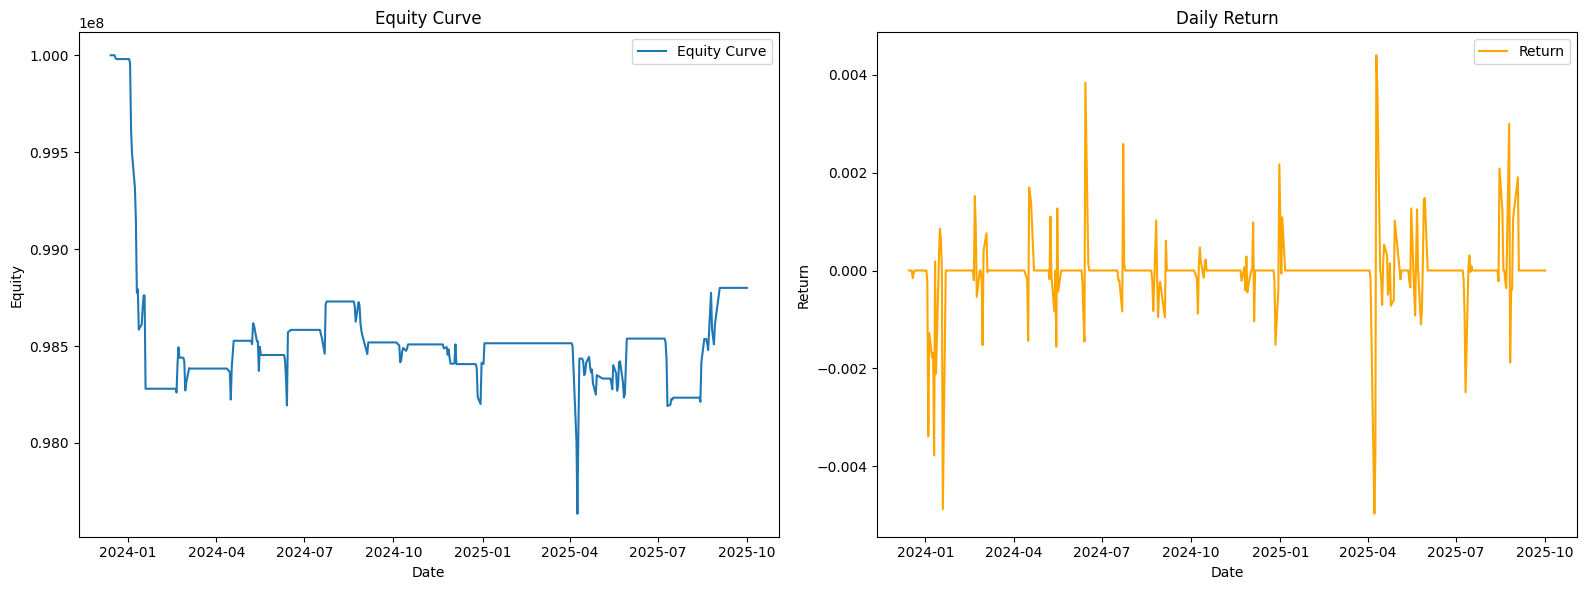

In [41]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Equity Curve on the first subplot
axes[0].plot(df_res2["equity"], label='Equity Curve')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Equity')
axes[0].set_title('Equity Curve')
axes[0].legend()

# Plot Return
axes[1].plot(df_res2["return"], label='Return', color='orange')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Return')
axes[1].set_title('Daily Return')
axes[1].legend()

plt.tight_layout() #
plt.show()

##Bench mark

In [42]:
import pandas as pd
# 2 cols lấy từ cặp kiểm định có thể tùy chỉnh
col1, col2 = 'BID.VN','VCB.VN'
data = pd.read_csv('data_10y.csv', header=[0, 1], index_col=0, parse_dates=True)
df = pd.DataFrame({
    col1: data['Close'][col1],
    col2: data['Close'][col2]
})

df = df.ffill()
split_point = int(len(df) * 0.8)
df_train = df.iloc[:split_point]
df_test = df.iloc[split_point:]

In [43]:
def benchmark_pair(df_test, col1, col2, initial_cash=1_000_000):
    """
    Tạo benchmark Buy & Hold cho cặp cổ phiếu trên df_test và tính performance.

    Args:
        df_test: DataFrame chứa giá cổ phiếu
        col1, col2: tên cột giá cổ phiếu
        initial_cash: vốn khởi tạo

    Returns:
        bench_df: DataFrame chứa equity và return hàng ngày
        performance: dict performance giống backtest
    """
    df = df_test.copy()

    # Start price
    start_price1 = df[col1].iloc[0]
    start_price2 = df[col2].iloc[0]

    # Buy & Hold từng cổ phiếu
    df[f"{col1}_B&H"] = initial_cash * df[col1] / start_price1
    df[f"{col2}_B&H"] = initial_cash * df[col2] / start_price2

    # Equity trung bình của cặp
    df["equity"] = (df[f"{col1}_B&H"] + df[f"{col2}_B&H"]) / 2

    # Tính return hàng ngày
    df["return"] = df["equity"].pct_change().fillna(0)

    # ==================================================
    # Performance metrics
    # ==================================================
    equity_series = df["equity"]
    final_equity = equity_series.iloc[-1]
    net_pnl = final_equity - initial_cash
    years = len(equity_series) / 252
    total_return = final_equity / initial_cash
    cagr = total_return ** (1 / years) - 1 if years > 0 else 0

    returns = equity_series.pct_change().dropna()
    volatility = returns.std() * np.sqrt(252) if len(returns) > 0 else 0
    sharpe = (returns.mean() / (returns.std() + 1e-9)) * np.sqrt(252) if len(returns) > 0 else 0

    performance = {
        "Final Equity": final_equity,
        "Net P/L": net_pnl,
        "Annualized Return": cagr,
        "Annualized Volatility": volatility,
        "Sharpe Ratio": sharpe,
        "Total Trades": 0
    }

    return df[["equity", "return"]], performance


In [44]:
# df_test
bench,performance = benchmark_pair(df_test, "BID.VN", "VCB.VN", initial_cash=100_000_000)
print(performance)

{'Final Equity': np.float64(114874656.51905718), 'Net P/L': np.float64(14874656.519057184), 'Annualized Return': np.float64(0.07239062786562811), 'Annualized Volatility': np.float64(0.2009911880164561), 'Sharpe Ratio': np.float64(0.4489030252722886), 'Total Trades': 0}


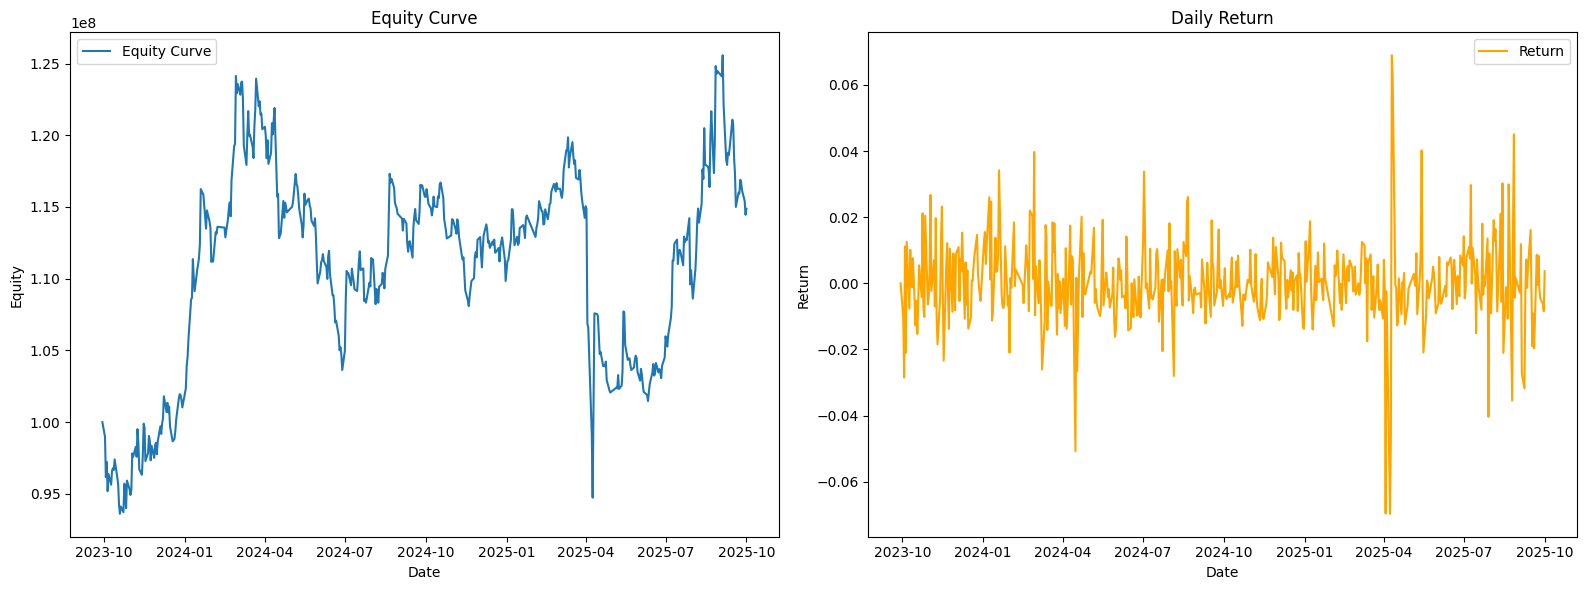

In [45]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Equity Curve
axes[0].plot(bench["equity"], label='Equity Curve')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Equity')
axes[0].set_title('Equity Curve')
axes[0].legend()

# Plot Return
axes[1].plot(bench["return"], label='Return', color='orange')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Return')
axes[1].set_title('Daily Return')
axes[1].legend()

plt.tight_layout()
plt.show()

# So sánh với bench mark

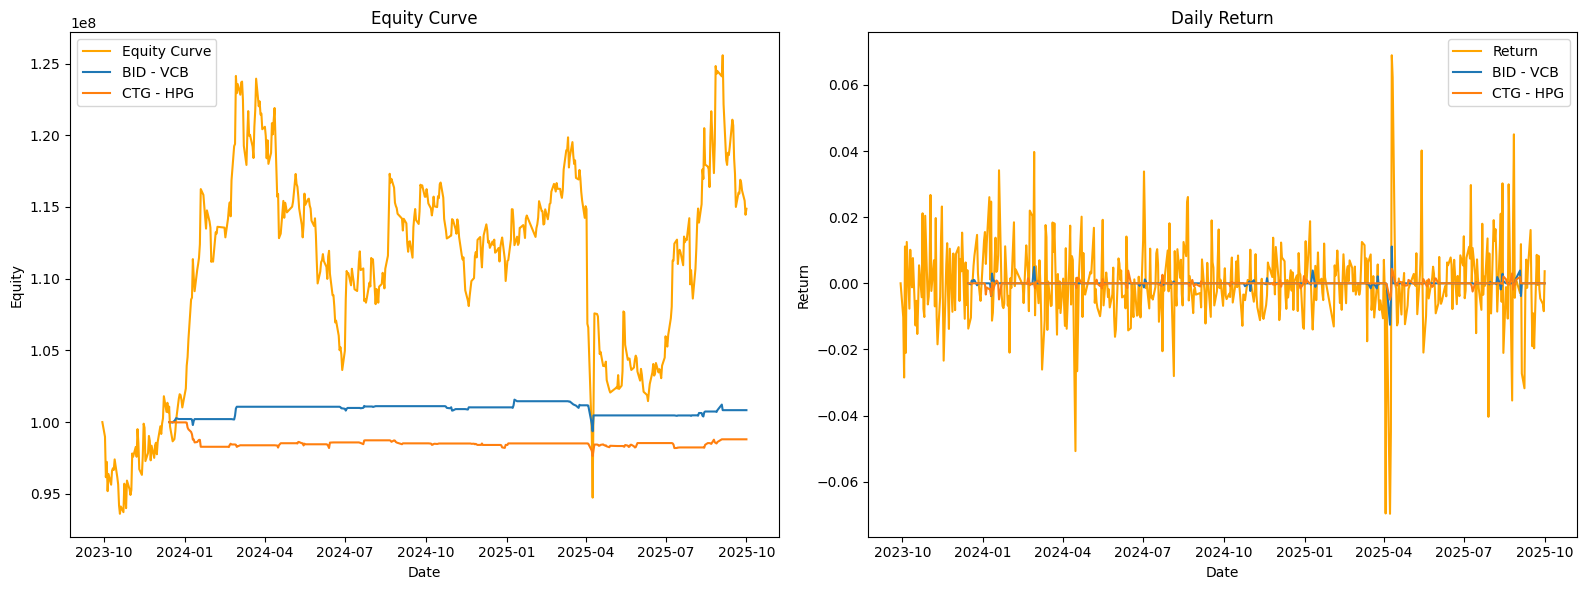

In [52]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot Equity Curve
axes[0].plot(bench["equity"], label='Equity Curve',color ='orange')
axes[0].plot(df_res1["equity"], label='BID - VCB')
axes[0].plot(df_res2["equity"], label='CTG - HPG')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Equity')
axes[0].set_title('Equity Curve')
axes[0].legend()

# Plot Return
axes[1].plot(bench["return"], label='Return', color='orange')
axes[1].plot(df_res1["return"], label='BID - VCB')
axes[1].plot(df_res2["return"], label='CTG - HPG')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Return')
axes[1].set_title('Daily Return')
axes[1].legend()

plt.tight_layout()
plt.show()

##Trade đổi cặp (unfinished)

Lý thuyết Pair Trading :

- Khi cointegration bị phá vỡ

  - p-value ADF > 0.05 → không còn mean-reverting

  - Hurst > 0.5 → trending

  - Half-life > 80 → mean reversion quá chậm

- Khi hiệu suất giao dịch quá kém

  - Drawdown > 10-20%

  - Sharpe < 0 trong 60 ngày

  - Số tín hiệu giảm (volatility spread thấp bất thường)

- Khi có cặp tốt hơn xuất hiện

  - Kiểm tra danh sách cặp candidate

  - Chọn cặp có p-value nhỏ nhất

  - Hurst < 0.5

  - Half-life nhỏ nhất

In [47]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from tqdm import tqdm

# ==========================================
# PRECOMPUTE COINTEGRATION METRICS FOR ALL PAIRS
# ==========================================
def precompute_metrics(df, pairs, window=60):
    metrics_cache = {}

    for col1, col2 in tqdm(pairs, desc="Precomputing metrics"):

        spread = df[col1] - df[col2]

        adf_list = []
        hurst_list = []
        hl_list = []

        # Rolling windows
        for i in range(len(df)):
            if i < window:
                adf_list.append(np.nan)
                hurst_list.append(np.nan)
                hl_list.append(np.nan)
                continue

            sp = spread.iloc[i-window:i].dropna()
            if len(sp) < window * 0.8:
                adf_list.append(np.nan)
                hurst_list.append(np.nan)
                hl_list.append(np.nan)
                continue

            # ====== ADF ======
            try:
                adf_stat, adf_p, _, _, _, _ = adfuller(sp, autolag="AIC")
            except:
                adf_p = np.nan

            # ====== Hurst ======
            try:
                lags = range(2, 50)
                tau = [np.sqrt(np.std(np.subtract(sp[l:], sp[:-l]))) for l in lags]
                poly = np.polyfit(np.log(lags), np.log(tau), 1)
                hurst = poly[0] * 2.0
            except:
                hurst = np.nan

            # ====== Half-life ======
            try:
                lagged = sp.shift(1).dropna()
                delta = sp.diff().dropna()

                model = sm.OLS(delta, sm.add_constant(lagged)).fit()
                hl = -np.log(2) / model.params[1]
            except:
                hl = np.nan

            adf_list.append(adf_p)
            hurst_list.append(hurst)
            hl_list.append(hl)

        metrics_cache[(col1, col2)] = pd.DataFrame({
            "adf_p": adf_list,
            "hurst": hurst_list,
            "half_life": hl_list
        })

    return metrics_cache


In [48]:
def backtest_pair_dynamic_switching(
    df,
    pairs,
    metrics_cache,
    window,
    entry_z,
    exit_z,
    max_risk_per_trade,
    drawdown_limit,
    sharpe_limit,
    initial_cash=100_000_000
):
    equity_curve = []
    trade_log = []

    position = 0
    pnl = 0
    entry_spread = None
    current_pair = None

    # -----------------------------------------
    # Select best pair using precomputed metrics
    # -----------------------------------------
    def pick_pair(i):
        scores = []

        for col1, col2 in pairs:
            m = metrics_cache[(col1, col2)].iloc[i]

            if pd.isna(m.adf_p) or pd.isna(m.hurst) or pd.isna(m.half_life):
                continue

            if m.adf_p < 0.05 and m.hurst < 0.5 and m.half_life < 80:
                scores.append((m.adf_p, m.half_life, col1, col2))

        if len(scores) == 0:
            return None

        scores.sort(key=lambda x: (x[0], x[1]))  # adf_p, hl
        _, _, c1, c2 = scores[0]
        return c1, c2

    # -----------------------------------------
    # MAIN BACKTEST LOOP
    # -----------------------------------------
    for i in range(window, len(df)):
        eq = initial_cash + pnl
        equity_curve.append(eq)

        # Pick pair if none
        if current_pair is None:
            current_pair = pick_pair(i)
            continue

        col1, col2 = current_pair

        # --- Compute beta using recent window ---
        win = df[[col1, col2]].iloc[i-window:i].dropna()
        beta = np.polyfit(win[col2], win[col1], 1)[0]

        # --- Compute spread + z-score ---
        spread_series = df[col1] - beta * df[col2]
        sp_win = spread_series.iloc[i-window:i]
        mean, std = sp_win.mean(), sp_win.std()
        z = (spread_series.iloc[i] - mean) / (std + 1e-9)

        # --- Automatic switching ---
        m = metrics_cache[(col1, col2)].iloc[i]
        if m.adf_p > 0.05 or m.hurst > 0.5 or m.half_life > 80:
            current_pair = pick_pair(i)
            position = 0
            continue

        # --- Performance filters ---
        if len(equity_curve) > 60:
            series = pd.Series(equity_curve)
            ret60 = series.diff().iloc[-60:]
            sharpe = ret60.mean() / (ret60.std() + 1e-9)
            dd = (series.max() - series.iloc[-1]) / series.max()

            if sharpe < sharpe_limit or dd > drawdown_limit:
                current_pair = pick_pair(i)
                position = 0
                continue

        # --- Risk budget ---
        cash = equity_curve[-1]
        pos_value = cash * max_risk_per_trade

        # --------------------------
        # ENTRY
        # --------------------------
        if position == 0:
            if z > entry_z:
                position = -pos_value     # short spread
                entry_spread = spread_series.iloc[i]

            elif z < -entry_z:
                position = +pos_value     # long spread
                entry_spread = spread_series.iloc[i]

        # --------------------------
        # EXIT
        # --------------------------
        else:
            if abs(z) < exit_z:
                profit = (entry_spread - spread_series.iloc[i]) * np.sign(position) * (abs(position)/1_000_000)
                pnl += profit

                trade_log.append({
                    "pair": f"{col1}-{col2}",
                    "pnl": profit,
                    "index": i,
                    "side": "LONG" if position > 0 else "SHORT"
                })

                position = 0

    # -----------------------------------------
    # PERFORMANCE
    # -----------------------------------------
    eq = pd.Series(equity_curve)
    years = len(eq) / 252

    performance = {
        "Final Equity": eq.iloc[-1],
        "Net P/L": eq.iloc[-1] - initial_cash,
        "Annualized Return": (eq.iloc[-1] / initial_cash) ** (1/years) - 1,
        "Annualized Volatility": eq.pct_change().std() * np.sqrt(252),
        "Sharpe Ratio": eq.pct_change().mean() / (eq.pct_change().std() + 1e-9) * np.sqrt(252),
        "Total Trades": len(trade_log),
    }

    return {
        "equity_curve": eq,
        "trade_log": pd.DataFrame(trade_log),
        "performance": performance
    }


In [49]:
import optuna

def optimize_dynamic_pair(
    df,
    pairs,
    metrics_cache,
    n_trials=20
):

    def objective(trial):
        window = trial.suggest_int("window", 30, 120)
        entry_z = trial.suggest_float("entry_z", 1.5, 3.5)
        exit_z = trial.suggest_float("exit_z", 0.3, 1.5)
        max_risk_per_trade = trial.suggest_float("max_risk_per_trade", 0.01, 0.25)
        drawdown_limit = trial.suggest_float("drawdown_limit", 0.05, 0.25)
        sharpe_limit = trial.suggest_float("sharpe_limit", -1, 1)

        result = backtest_pair_dynamic_switching(
            df=df,
            pairs=pairs,
            metrics_cache=metrics_cache,
            window=window,
            entry_z=entry_z,
            exit_z=exit_z,
            max_risk_per_trade=max_risk_per_trade,
            drawdown_limit=drawdown_limit,
            sharpe_limit=sharpe_limit
        )

        return result["performance"]["Sharpe Ratio"]

    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    return study.best_params, study.best_value, study


In [50]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# =====================================================
# 1. HÀM TÍNH COINTEGRATION (ADF, Hurst, Half-life)
# =====================================================
def calc_cointegration_metrics(spread):
    spread = spread.dropna()

    # Không đủ dữ liệu → trả về giá trị "xấu" để bị loại
    if len(spread) < 20:
        return 1.0, 1.0, 999.0   # adf_p cao, hurst > 0.5, half-life quá lớn

    # ADF test
    try:
        adf_stat, adf_p, _, _, critical, _ = adfuller(spread, autolag='AIC')
    except:
        return 1.0, 1.0, 999.0

    # Hurst exponent
    try:
        lags = range(2, min(100, len(spread) - 1))
        tau = [np.sqrt(np.std(np.subtract(spread[l:], spread[:-l]))) for l in lags]
        poly = np.polyfit(np.log(lags), np.log(tau), 1)
        hurst = poly[0] * 2.0
    except:
        hurst = 1.0

    # Half-life
    try:
        spread_lag = spread.shift(1)
        spread_lag.iloc[0] = spread_lag.iloc[1]  #Không lỗi vì spread >= 20
        delta = spread - spread_lag
        model = sm.OLS(delta[1:], sm.add_constant(spread_lag[1:])).fit()
        halflife = -np.log(2) / model.params[1]
    except:
        halflife = 999.0

    return adf_p, hurst, halflife

# =====================================================
# 2. HÀM CHỌN CẶP TỐT NHẤT
# =====================================================
def select_best_pair(df, pairs, i, window):
    metrics = []
    for col1, col2 in pairs:
        spread = df[col1] - df[col2]
        sp = spread.iloc[i-window:i].dropna()

        if len(sp) < window * 0.8:
            continue

        adf_p, hurst, hl = calc_cointegration_metrics(sp)
        metrics.append({
            "pair": (col1, col2),
            "adf_p": adf_p,
            "hurst": hurst,
            "half_life": hl
        })

    if len(metrics) == 0:
        return None

    m = pd.DataFrame(metrics)
    m = m[(m["adf_p"] < 0.05) & (m["hurst"] < 0.5) & (m["half_life"] < 80)]

    if len(m) == 0:
        return None

    m = m.sort_values(["adf_p", "half_life"])
    return tuple(m.iloc[0]["pair"])

# =====================================================
# 3. HÀM BACKTEST FULL
# =====================================================
def backtest_pair_dynamic_switching(
    df,
    pairs,
    window=60,
    entry_z=2.0,
    exit_z=0.5,
    max_risk=0.1,
    initial_cash=1_000_000
):
    df = df.reset_index(drop=True)
    equity = initial_cash
    equity_curve = []
    trade_log = []

    position = 0
    entry_spread = None
    current_pair = None

    for i in range(window, len(df)):

        # Switch nếu không có cặp
        if current_pair is None:
            current_pair = select_best_pair(df, pairs, i, window)
            equity_curve.append(equity)
            continue

        col1, col2 = current_pair

        spread = df[col1] - df[col2]
        sp = spread.iloc[i-window:i]
        mean = sp.mean()
        std = sp.std()
        z = (spread.iloc[i] - mean) / std

        # Cointegration check
        adf_p, hurst, hl = calc_cointegration_metrics(sp)
        if adf_p > 0.05 or hurst > 0.5 or hl > 80:
            current_pair = select_best_pair(df, pairs, i, window)
            position = 0
            equity_curve.append(equity)
            continue

        # ---- ENTRY ----
        if position == 0:
            if z > entry_z:
                position = -1
                entry_spread = spread.iloc[i]
            elif z < -entry_z:
                position = +1
                entry_spread = spread.iloc[i]

        # ---- EXIT ----
        else:
            if abs(z) < exit_z:
                pnl = position * (entry_spread - spread.iloc[i])
                pnl = max(min(pnl, equity * max_risk), -equity * max_risk)

                equity += pnl

                trade_log.append({
                    "pair": f"{col1}-{col2}",
                    "pos": "LONG" if position == 1 else "SHORT",
                    "entry": float(entry_spread),
                    "exit": float(spread.iloc[i]),
                    "pnl": float(pnl)
                })
                position = 0

        # Mark-to-market
        if position != 0:
            mtm = position * (entry_spread - spread.iloc[i])
            mtm = max(min(mtm, equity * max_risk), -equity * max_risk)
            equity_curve.append(equity + mtm)
        else:
            equity_curve.append(equity)

    return pd.Series(equity_curve), pd.DataFrame(trade_log)

# =====================================================
# 4. TẠO DỮ LIỆU GIẢ ĐỂ TEST
# =====================================================
np.random.seed(42)
n = 500

spread_ab = np.random.normal(0,1,n).cumsum()
df = pd.DataFrame({
    "A": spread_ab + np.random.normal(0,0.2,n),
    "B": spread_ab + np.random.normal(0,0.2,n),
})

spread_cd = np.random.normal(0,1,n).cumsum()*1.8
df["C"] = spread_cd + np.random.normal(0,0.3,n)
df["D"] = spread_cd + np.random.normal(0,0.3,n)

pairs = [("A","B"), ("C","D")]

# =====================================================
# 5. CHẠY THỬ 1 LẦN
# =====================================================
equity, log = backtest_pair_dynamic_switching(df, pairs)

print("=== PERFORMANCE ===")
print(f"Final Equity: {equity.iloc[-1]:,.2f}")
print(f"Net P/L: {equity.iloc[-1] - 1_000_000:,.2f}")
print("Total trades:", len(log))

print("\n=== TRADE LOG (5 dòng đầu) ===")
print(log.head())


=== PERFORMANCE ===
Final Equity: 1,000,000.00
Net P/L: 0.00
Total trades: 0

=== TRADE LOG (5 dòng đầu) ===
Empty DataFrame
Columns: []
Index: []


#Nháp

In [51]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
import optuna
import warnings
warnings.filterwarnings("ignore")


# -------------------------
# Helpers: cointegration metrics, rolling beta
# -------------------------
def calc_cointegration_metrics(spread_series):
    s = spread_series.dropna()
    if len(s) < 10:
        return 1.0, np.nan, np.inf

    try:
        _, pvalue, _, _, _, _ = adfuller(s, autolag="AIC")
    except Exception:
        pvalue = 1.0

    # Hurst (simple)
    try:
        lags = range(2, min(100, len(s)//2 + 2))
        tau = [np.sqrt(np.std(np.subtract(s[l:], s[:-l]))) for l in lags]
        poly = np.polyfit(np.log(lags), np.log(tau), 1)
        hurst = float(poly[0] * 2.0)
    except Exception:
        hurst = np.nan

    # half-life
    try:
        s_lag = s.shift(1)
        s_lag.iloc[0] = s_lag.iloc[1]
        delta = s - s_lag
        model = sm.OLS(delta[1:], sm.add_constant(s_lag[1:])).fit()
        theta = model.params[1]
        halflife = -np.log(2) / theta if theta < 0 else np.inf
    except Exception:
        halflife = np.inf

    return pvalue, hurst, halflife


def rolling_beta(y_series, x_series):
    """
    OLS beta for y = alpha + beta * x on two pd.Series (aligned).
    Return np.nan if not enough data or failure.
    """
    y = y_series.dropna()
    x = x_series.dropna()
    if len(y) < 8 or len(x) < 8 or len(y) != len(x):
        return np.nan
    X = sm.add_constant(x)
    try:
        model = sm.OLS(y, X).fit()
        return float(model.params[1])
    except Exception:
        return np.nan


# -------------------------
# Main backtest: dynamic switching with beta + sizing
# -------------------------
def backtest_pair_dynamic_switching(
    df,                    # price DataFrame (columns = tickers)
    pairs,                 # list of candidate tuples [('A','B'), ...]
    window=60,             # rolling window for beta & stats
    entry_z=2.0,
    exit_z=0.5,
    drawdown_limit=0.15,
    sharpe_limit=0.0,
    initial_cash=100_000_000,
    max_risk_per_trade=0.02,
    buy_fee=0.001,         # per-leg fee placeholders (not split per leg here)
    sell_fee=0.002,
    min_history_frac=0.8,
    debug=False
):
    """
    Returns: { 'equity_curve': pd.Series (indexed from df.index[window:]),
               'trade_log': pd.DataFrame,
               'performance': dict }
    Notes:
      - Only one pair traded at a time (switching).
      - Position sizing uses `max_risk_per_trade` (fraction of NAV risked if stop hit).
      - Spread uses rolling beta: spread_t = p1_t - beta_t * p2_t (beta from last 'window' history).
    """

    n = len(df)
    if n <= window:
        raise ValueError("df length must exceed window")

    equity_vals = []
    trade_log = []
    cash = float(initial_cash)   # cash + realized pnl tracked via cash
    unreal_pnl = 0.0
    total_trades = 0

    current_pair = None         # (c1, c2)
    current_beta = np.nan
    position = 0                # 0 flat, +1 long spread, -1 short spread
    entry_spread = None
    position_value = 0.0        # monetary exposure sized by max_risk_per_trade

    def select_best_pair(i):
        metrics = []
        start = i - window
        for c1, c2 in pairs:
            p1 = df[c1].iloc[start:i]
            p2 = df[c2].iloc[start:i]
            if p1.dropna().shape[0] < window * min_history_frac or p2.dropna().shape[0] < window * min_history_frac:
                continue
            beta = rolling_beta(p1, p2)
            if np.isnan(beta):
                continue
            spread = p1 - beta * p2
            adf_p, hurst, hl = calc_cointegration_metrics(spread)
            metrics.append({"pair": (c1, c2), "adf_p": adf_p, "hurst": hurst, "hl": hl, "beta": beta})
        if len(metrics) == 0:
            return None
        m = pd.DataFrame(metrics)
        # filters per theory
        m = m[m["hurst"] < 0.5]
        m = m[m["adf_p"] < 0.05]
        m = m[m["hl"] < 80]
        if m.shape[0] == 0:
            return None
        m = m.sort_values(by=["adf_p", "hl"])
        row = m.iloc[0]
        return (row["pair"][0], row["pair"][1], float(row["beta"]))

    # main loop over time (we produce equity entries aligned to df.index[window:])
    for i in range(window, n):
        # 1) if no current pair, try select
        if current_pair is None:
            sel = select_best_pair(i)
            if sel is None:
                equity_vals.append(cash + unreal_pnl)
                continue
            current_pair = (sel[0], sel[1])
            current_beta = sel[2]
            if debug:
                print(f"[{i}] select {current_pair} beta={current_beta:.4f}")
            equity_vals.append(cash + unreal_pnl)
            continue

        # 2) compute rolling beta for current pair
        c1, c2 = current_pair
        p1_hist = df[c1].iloc[i - window:i]
        p2_hist = df[c2].iloc[i - window:i]
        beta_i = rolling_beta(p1_hist, p2_hist)
        if np.isnan(beta_i):
            # force close and reselection
            if position != 0:
                # close at today's approximation using previous beta if available
                beta_use = current_beta if not np.isnan(current_beta) else 1.0
                spread_now = df[c1].iloc[i] - beta_use * df[c2].iloc[i]
                pnl_trade = position * (entry_spread - spread_now) * position_value
                cash += pnl_trade
                trade_log.append({"type": "FORCE_CLOSE", "pair": f"{c1}-{c2}", "index": i, "pnl": pnl_trade})
                total_trades += 1
                position = 0
                entry_spread = None
                position_value = 0.0
            current_pair = None
            equity_vals.append(cash + unreal_pnl)
            continue
        current_beta = beta_i

        # 3) compute spread/z using rolling stats (window)
        spread_series = p1_hist - current_beta * p2_hist
        mean = spread_series.mean()
        std = spread_series.std(ddof=0) if spread_series.std(ddof=0) > 0 else np.nan
        spread_now = df[c1].iloc[i] - current_beta * df[c2].iloc[i]
        z = (spread_now - mean) / (std + 1e-12) if (not np.isnan(std) and std > 0) else np.nan

        # 4) cointegration checks -> if broken, close and reselect
        adf_p, hurst, hl = calc_cointegration_metrics(spread_series)
        if (np.isnan(adf_p) or adf_p > 0.05) or (not np.isnan(hurst) and hurst > 0.5) or (hl > 80):
            if position != 0:
                pnl_trade = position * (entry_spread - spread_now) * position_value
                cash += pnl_trade
                trade_log.append({"type": "COINT_BREAK_CLOSE", "pair": f"{c1}-{c2}", "index": i, "pnl": pnl_trade,
                                  "adf_p": adf_p, "hurst": hurst, "hl": hl})
                total_trades += 1
                position = 0
                entry_spread = None
                position_value = 0.0
            # reselection
            sel = select_best_pair(i)
            if sel is None:
                current_pair = None
                equity_vals.append(cash + unreal_pnl)
                continue
            current_pair = (sel[0], sel[1])
            current_beta = sel[2]
            if debug:
                print(f"[{i}] coint break -> switched to {current_pair} beta={current_beta:.4f}")
            equity_vals.append(cash + unreal_pnl)
            continue

        # 5) performance checks (rolling)
        if len(equity_vals) > 100:
            recent_rets = pd.Series(equity_vals).diff().dropna().iloc[-60:]
            sharpe = recent_rets.mean() / (recent_rets.std() + 1e-12) if len(recent_rets) > 1 else np.nan
            peak = np.max(equity_vals)
            dd = (peak - equity_vals[-1]) / (peak + 1e-12)
            if (not np.isnan(sharpe) and sharpe < sharpe_limit) or (dd > drawdown_limit):
                if position != 0:
                    pnl_trade = position * (entry_spread - spread_now) * position_value
                    cash += pnl_trade
                    trade_log.append({"type": "PERF_CLOSE", "pair": f"{c1}-{c2}", "index": i, "pnl": pnl_trade,
                                      "sharpe": sharpe, "dd": dd})
                    total_trades += 1
                    position = 0
                    entry_spread = None
                    position_value = 0.0
                sel = select_best_pair(i)
                if sel is None:
                    current_pair = None
                    equity_vals.append(cash + unreal_pnl)
                    continue
                current_pair = (sel[0], sel[1])
                current_beta = sel[2]
                if debug:
                    print(f"[{i}] perf filter -> switched to {current_pair} beta={current_beta:.4f}")
                equity_vals.append(cash + unreal_pnl)
                continue

        # 6) entry / switch / exit logic with sizing
        if position == 0:
            if (not np.isnan(z)) and (z > entry_z or z < -entry_z):
                stop_range = abs(entry_z - exit_z) * std if (not np.isnan(std) and std > 0) else np.nan
                if np.isnan(stop_range) or stop_range == 0:
                    equity_vals.append(cash + unreal_pnl)
                    continue
                nav = cash + unreal_pnl
                max_risk_money = nav * max_risk_per_trade
                position_value = max_risk_money / stop_range  # monetary exposure to spread
                direction = -1 if z > entry_z else 1
                position = direction
                entry_spread = spread_now
                trade_log.append({"type": "ENTRY", "pair": f"{c1}-{c2}", "index": i, "z": float(z),
                                  "dir": "SHORT" if direction==-1 else "LONG", "beta": float(current_beta),
                                  "pos_value": float(position_value), "nav_before": float(nav)})
                total_trades += 1
        else:
            # immediate switch case
            if (position == 1 and (not np.isnan(z)) and z > entry_z) or (position == -1 and (not np.isnan(z)) and z < -entry_z):
                pnl_trade = position * (entry_spread - spread_now) * position_value
                cash += pnl_trade
                trade_log.append({"type": "SWITCH_EXIT", "pair": f"{c1}-{c2}", "index": i, "pnl": pnl_trade, "z": float(z)})
                total_trades += 1

                # enter opposite
                stop_range = abs(entry_z - exit_z) * std if (not np.isnan(std) and std > 0) else np.nan
                if np.isnan(stop_range) or stop_range == 0:
                    position = 0
                    entry_spread = None
                    position_value = 0.0
                    equity_vals.append(cash + unreal_pnl)
                    continue
                nav = cash + unreal_pnl
                max_risk_money = nav * max_risk_per_trade
                position_value = max_risk_money / stop_range
                position = -position
                entry_spread = spread_now
                trade_log.append({"type": "SWITCH_ENTRY", "pair": f"{c1}-{c2}", "index": i, "z": float(z),
                                  "new_dir": "SHORT" if position==-1 else "LONG", "pos_value": float(position_value)})
                total_trades += 1

            # normal exit
            elif (not np.isnan(z)) and (abs(z) < exit_z):
                pnl_trade = position * (entry_spread - spread_now) * position_value
                cash += pnl_trade
                trade_log.append({"type": "EXIT", "pair": f"{c1}-{c2}", "index": i, "pnl": pnl_trade, "z": float(z)})
                total_trades += 1
                position = 0
                entry_spread = None
                position_value = 0.0

        # mark-to-market
        if position != 0 and entry_spread is not None:
            mtm = position * (entry_spread - spread_now) * position_value
            unreal_pnl = mtm
            equity_vals.append(cash + unreal_pnl)
        else:
            unreal_pnl = 0.0
            equity_vals.append(cash + unreal_pnl)

    # build outputs
    equity_index = df.index[window:]
    equity_series = pd.Series(equity_vals, index=equity_index)

    final_nav = float(equity_series.iloc[-1]) if len(equity_series) > 0 else float(initial_cash)
    total_return = final_nav / initial_cash if initial_cash != 0 else 1.0
    n_days = len(equity_series)
    years = n_days / 252.0 if n_days > 0 else 0.0
    cagr = (total_return ** (1.0 / years) - 1.0) if years > 0 else 0.0

    rets = equity_series.pct_change().dropna()
    volatility = float(rets.std() * np.sqrt(252)) if len(rets) > 0 else 0.0
    sharpe = float((rets.mean() / (rets.std() + 1e-12)) * np.sqrt(252)) if len(rets) > 0 else 0.0

    performance = {
        "Final Equity": final_nav,
        "Net P/L": final_nav - initial_cash,
        "Annualized Return": cagr,
        "Annualized Volatility": volatility,
        "Sharpe Ratio": sharpe,
        "Total Trades": total_trades
    }

    trade_log_df = pd.DataFrame(trade_log)

    return {"equity_curve": equity_series, "trade_log": trade_log_df, "performance": performance}


# -------------------------
# Optuna objective using time-series CV (TimeSeriesSplit)
# -------------------------
def optuna_optimize_pairs(
    df_train,
    pairs,
    n_trials=30,
    n_splits=3,
    seed=42,
    show_progress=False
):
    tscv = TimeSeriesSplit(n_splits=n_splits)

    def objective(trial):
        # sample params
        window = trial.suggest_int("window", 30, 120)
        entry_z = trial.suggest_float("entry_z", 1.2, 3.0)
        exit_z = trial.suggest_float("exit_z", 0.1, 1.2)
        max_risk = trial.suggest_float("max_risk_per_trade", 0.005, 0.25)
        drawdown_limit = trial.suggest_float("drawdown_limit", 0.05, 0.25)
        sharpe_limit = trial.suggest_float("sharpe_limit", -1.0, 0.5)

        sharpe_list = []
        for train_idx, val_idx in tscv.split(df_train):
            # build data for fold: use full train window up to val start for selection, then run backtest on val
            df_train_fold = df_train.iloc[train_idx]
            df_val_fold = df_train.iloc[val_idx]

            # we need a combined df (train+val) for rolling-beta stats but will evaluate performance only on val period:
            df_combined = pd.concat([df_train_fold, df_val_fold]).reset_index(drop=True)

            try:
                out = backtest_pair_dynamic_switching(
                    df_combined,
                    pairs=pairs,
                    window=window,
                    entry_z=entry_z,
                    exit_z=exit_z,
                    drawdown_limit=drawdown_limit,
                    sharpe_limit=sharpe_limit,
                    initial_cash=100_000_000,
                    max_risk_per_trade=max_risk,
                    min_history_frac=0.8,
                    debug=False
                )
                perf = out["performance"]
                sharpe_fold = perf.get("Sharpe Ratio", np.nan)
                if np.isnan(sharpe_fold):
                    return -999
                sharpe_list.append(sharpe_fold)
            except Exception:
                return -999

        if len(sharpe_list) == 0:
            return -999
        return float(np.mean(sharpe_list))

    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=seed))
    study.optimize(objective, n_trials=n_trials, show_progress_bar=show_progress)
    return study


# -------------------------
# Example usage
# -------------------------
if __name__ == "__main__":
    # ---- create synthetic cointegrated data ----
    np.random.seed(0)
    n = 800
    A = 100 + np.cumsum(np.random.normal(0, 1, n))
    spread = np.zeros(n)
    for t in range(1, n):
        spread[t] = 0.9 * spread[t-1] + np.random.normal(0, 0.5)
    B = A + spread

    C = 80 + np.cumsum(np.random.normal(0, 1, n))
    spread2 = np.zeros(n)
    for t in range(1, n):
        spread2[t] = 0.85 * spread2[t-1] + np.random.normal(0, 0.6)
    D = C + spread2

    dates = pd.date_range("2018-01-01", periods=n, freq="B")
    df_all = pd.DataFrame({"A": A, "B": B, "C": C, "D": D}, index=dates)

    pairs = [("A","B"), ("C","D")]

    # ---- split train/test ----
    split = int(0.7 * len(df_all))
    df_train = df_all.iloc[:split].copy()
    df_test = df_all.iloc[split:].copy()

    # ---- run Optuna on train ----
    study = optuna_optimize_pairs(df_train, pairs, n_trials=20, n_splits=3)
    print("Best params:", study.best_params)
    print("Best value (mean CV Sharpe):", study.best_value)

    # ---- evaluate on holdout (df_test) using best params ----
    best = study.best_params
    # combine last window from train with test so rolling stats have history
    df_hold = pd.concat([df_train.iloc[-max(200, best["window"]):], df_test]).reset_index(drop=True)
    out = backtest_pair_dynamic_switching(
        df_hold,
        pairs=pairs,
        window=best["window"],
        entry_z=best["entry_z"],
        exit_z=best["exit_z"],
        drawdown_limit=best["drawdown_limit"],
        sharpe_limit=best["sharpe_limit"],
        initial_cash=100_000_000,
        max_risk_per_trade=best["max_risk_per_trade"],
        debug=True
    )

    print("\nHOLDOUT PERFORMANCE:")
    print(out["performance"])
    print("\nTRADE LOG (first 10 rows):")
    print(out["trade_log"].head(10))


[I 2025-12-13 03:23:04,751] A new study created in memory with name: no-name-7d5506ed-0322-433c-b42c-54ce3ebe54c1
[I 2025-12-13 03:24:20,922] Trial 0 finished with value: 0.0 and parameters: {'window': 64, 'entry_z': 2.911285751537849, 'exit_z': 0.9051933359925455, 'max_risk_per_trade': 0.15167132862827398, 'drawdown_limit': 0.0812037280884873, 'sharpe_limit': -0.7660082194956961}. Best is trial 0 with value: 0.0.
[I 2025-12-13 03:25:01,782] Trial 1 finished with value: 0.0 and parameters: {'window': 35, 'entry_z': 2.7591170623948833, 'exit_z': 0.7612265129175296, 'max_risk_per_trade': 0.17847778156003113, 'drawdown_limit': 0.05411689885916049, 'sharpe_limit': 0.45486477824299154}. Best is trial 0 with value: 0.0.
[I 2025-12-13 03:26:26,119] Trial 2 finished with value: 0.0 and parameters: {'window': 105, 'entry_z': 1.5822103992208971, 'exit_z': 0.30000746392781064, 'max_risk_per_trade': 0.04993410491409128, 'drawdown_limit': 0.11084844859190755, 'sharpe_limit': -0.2128653525516433}. B

KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd

np.random.seed(42)
n = 1200

# Tạo chuỗi random walk làm asset A
A = 100 + np.cumsum(np.random.normal(0, 1, n))

# Tạo asset B = A + nhiễu mean-reverting
spread = np.zeros(n)
for i in range(1, n):
    spread[i] = 0.9 * spread[i-1] + np.random.normal(0, 0.5)

B = A + spread

# Tạo thêm 1 cặp khác cũng cointegrated
C = 80 + np.cumsum(np.random.normal(0, 1, n))
spread2 = np.zeros(n)
for i in range(1, n):
    spread2[i] = 0.85 * spread2[i-1] + np.random.normal(0, 0.7)
D = C + spread2

df = pd.DataFrame({
    "AAA": A,
    "BBB": B,
    "CCC": C,
    "DDD": D
})

pairs = [
    ("AAA", "BBB"),
    ("CCC", "DDD")
]

res = backtest_pair_dynamic_switching(
    df=df,
    pairs=pairs,
    window=60,
    entry_z=1.5,
    exit_z=0.3,
    drawdown_limit=0.2,
    sharpe_limit=-999,   # tắt filter Sharpe cho dễ chạy
    initial_cash=100_000_000
)

print("\n=== PERFORMANCE ===")
print(res["performance"])
print("\n=== TRADE LOG ===")
print(res["trade_log"].head())
print("\nFinal equity:", res["equity_curve"].iloc[-1])
